In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import nquad, dblquad, tplquad
from scipy.optimize import minimize_scalar, fsolve, brentq
from scipy.integrate import quad

from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from LensCalcPy.survey import *
from LensCalcPy.lens import *   
from LensCalcPy.pbh import *
from LensCalcPy.utils import *
from LensCalcPy.galaxy import *
from LensCalcPy.parameters import *


from fastcore.test import *

In [160]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [66]:
#| export


class Nfw(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                mw_model=None,
                l = None,
                b = None,
                ds = 770,
                ut_interp = None,
                r90 = None
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        self.mass = mass
        self.ut_interp = ut_interp
        self.ds = ds
        self.r90 = r90 #radius of 90% of the mass of the halo in kpc
    
    def __str__(self) -> str:
        return f"NFW population with mass={self.mass}"
    __repr__ = __str__


    def differential_rate_integrand(self, umin, d, t, model, finite=False, v_disp=None, t_e = False, tmax=np.inf, tmin=0, t_fwhm=False):

        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) 
        if ut <= umin:
            return 0
        if t_e: 
            #Calculate radial velocity in terms of einstein crossing time
            v_rad = einstein_rad(d, self.mass, self.ds) * kpctokm / (t * htosec) 
            t_duration = max(ut, self.umin_upper_bound(d)) * 2 * einstein_rad(d, self.mass) * kpctokm / v_rad / htosec #event duration in hours

            if t_duration > tmax or t_duration < tmin:
                return 0   
        else:
            #Calculate radial velocity in terms of event duration (t_fwhm)
            v_rad = velocity_radial(d, self.mass, umin, t * htosec, ut) 
        if v_disp is None: 
            v_disp = model.velocity_dispersion_dm(r)

        return 2 * (1 / (ut**2 - umin**2)**0.5 *
                model.density_dm(d, self.l, self.b) / (self.mass * v_disp**2) *  
                v_rad**4 * (htosec / kpctokm)**2 *
                np.exp(-(v_rad**2 / v_disp**2)) *
                1)

    def differential_rate_integrand_mw(self, umin, d, t, finite=False):
        return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite)
    
    
    def differential_rate(self, t, integrand_func, finite=False, epsabs=1.49e-08, epsrel=1.49e-08):

        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):
           
            u_min, u_max = 0, self.umin_upper_bound(d)
            
            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        d_min, d_max = 0, self.ds
        result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
        return result

    def rate_total(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):        

        # Innermost double integral
        def inner_integrand(u, d, t):
            return integrand_func(u, d, t)
        
        # Second integral (over u) - bounds given by d
        def second_integral(d, t):

            u_min, u_max = 0, self.umin_upper_bound(d)
            
            result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)

            return result
        
        # Outermost integral (over d)
        def outer_integral(t):
            d_min, d_max = 0, self.ds
            result, error = quad(second_integral, d_min, d_max, args=(t,), epsabs=epsabs, epsrel=epsrel)
            # return result * self.mass_function(mf) * mf * np.log(10)  # multiply by mass function and by dlogm * m
            return result  
        
        # Integrate over time
        result, error = quad(outer_integral, tcad, tobs, epsabs=epsabs, epsrel=epsrel)
        return result
    
    def rate_mw(self, finite=False, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand_mw(umin, d, t, finite=finite,)
        return self.rate_total(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    
    def differential_rate_mw(self, t, finite=True, v_disp=None, t_e=False, tmax=np.inf, tmin=0, t_fwhm=False):
        def integrand_func(umin, d, t):
            return self.differential_rate_integrand(umin, d, t, self.mw_model, finite=finite, v_disp=v_disp, t_e = t_e, tmax=tmax, tmin=tmin, t_fwhm=t_fwhm)
        return self.differential_rate(t, integrand_func, finite=finite)

    def umin_upper_bound(self, d, m=None):
        if m is None:
            m = self.mass
        rE = einstein_rad(d, m, self.ds)
        return self.ut_interp(self.r90/rE)
    
    def differential_rate_total(self, t, finite=True):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]
    


In [138]:
roman_df = pd.read_csv('roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))

In [2]:
df = pd.read_csv('extended_dat/nfw_134.csv', header=None)
ut_nfw_interp = interp1d(df[0], df[1], kind='linear')
def ut_nfw(r90_re):
    if r90_re < (ut_nfw_interp.x[0]):
        return 1
    elif r90_re > (ut_nfw_interp.x[-1]):
        return 0
    return ut_nfw_interp(r90_re)

In [3]:
r90_re_arr = np.logspace(-1,2,100)
ut_nfw_vals = np.array([ut_nfw(r90_re) for r90_re in r90_re_arr])

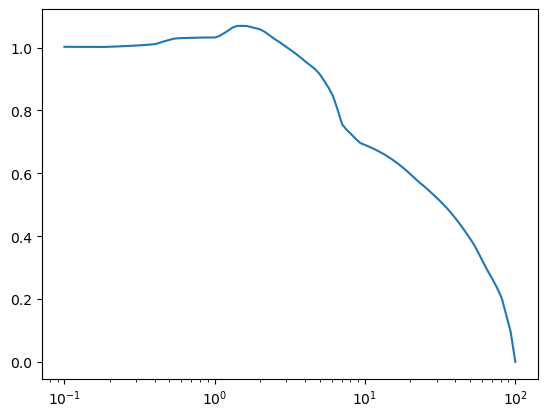

In [4]:
plt.plot(r90_re_arr, ut_nfw_vals)
plt.xscale('log')

In [87]:
# params = {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 6*72*24, "cadence": 15/60,  "n_sources": 2.4e8, "efficiency": 1, "A_t": 1.34, "survey_area":0}
params = {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 6*72*24, "cadence": 15/60,  "n_sources": 2.4e8, "efficiency": 1, "A_t": 1.34, "survey_area":0}


In [77]:
rsolkpc = 2.25e-11
nfw3=Nfw(1e-6, l=s.l, b=s.b, ds=s.source_dist, ut_interp=ut_nfw, r90=rsolkpc*3)
nfw30=Nfw(1e-6, l=s.l, b=s.b, ds=s.source_dist, ut_interp=ut_nfw, r90=rsolkpc*30)


In [82]:
ts = np.logspace(-2,2,40)
diff_rate_3 = np.array([nfw3.differential_rate_mw(t) for t in ts])
diff_rate_30 = np.array([nfw30.differential_rate_mw(t) for t in ts])

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53937/2342537050.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)


In [163]:
m_arr = np.logspace(-12, 1, 30)
rate_arr_0 = np.zeros_like(m_arr)
rate_arr_3 = np.zeros_like(m_arr)
rate_arr_30 = np.zeros_like(m_arr)
for i, m in enumerate(tqdm(m_arr)):
    nfw0 = Nfw(m, l=params['l'], b=params['b'], ds=params['source_dist'], ut_interp=ut_nfw, r90=0)
    nfw3 = Nfw(m, l=params['l'], b=params['b'], ds=params['source_dist'], ut_interp=ut_nfw, r90=rsolkpc*3)
    nfw30 = Nfw(m, l=params['l'], b=params['b'], ds=params['source_dist'], ut_interp=ut_nfw, r90=rsolkpc*30)
    rate_arr_0[i] = nfw0.rate_mw(tcad=params['cadence'], tobs=params['obs_time'], efficiency=roman_efficiency, epsabs=0, epsrel=1e-1)
    rate_arr_3[i] = nfw3.rate_mw(tcad=params['cadence'], tobs=params['obs_time'], efficiency=roman_efficiency, epsabs=0, epsrel=1e-1)
    rate_arr_30[i] = nfw30.rate_mw(tcad=params['cadence'], tobs=params['obs_time'], efficiency=roman_efficiency, epsabs=0, epsrel=1e-1)

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53937/2342537050.py:110: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  result, error = quad(outer_integral, tcad, tobs, epsabs=epsabs, epsrel=epsrel)
 10%|█         | 3/30 [00:32<04:47, 10.66s/it]

In [ ]:
def fdm_constraint(rate):
    return 4.61/ (rate*params['obs_time']*params['n_sources'])

In [ ]:
fdm_0 = fdm_constraint(rate_arr_0)
fdm_3 = fdm_constraint(rate_arr_3)
fdm_30 = fdm_constraint(rate_arr_30)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53937/4221481760.py:2: RuntimeWarning: divide by zero encountered in divide
  return 4.61/ (rate*params['obs_time']*params['n_sources'])


In [ ]:
fdm_0[np.where(fdm_0 == np.inf)] = 1
fdm_3[np.where(fdm_3 == np.inf)] = 1
fdm_30[np.where(fdm_30 == np.inf)] = 1

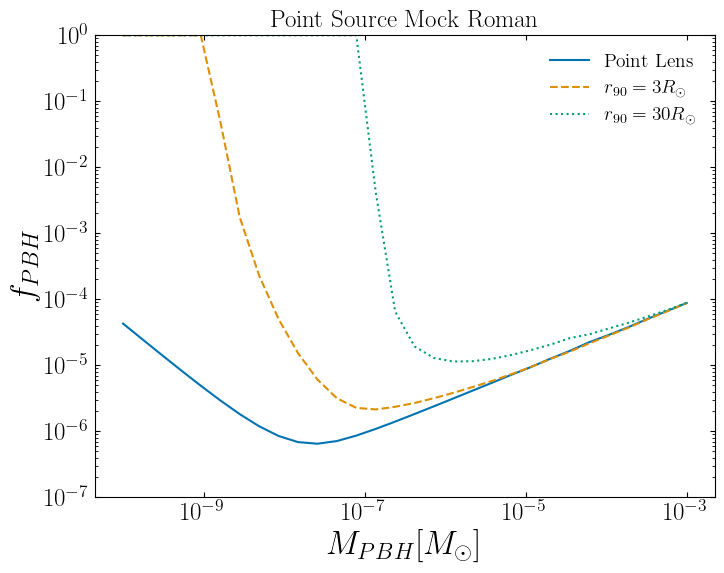

In [ ]:
#Real time parameters, higher precision
plt.loglog(m_arr, fdm_0, label='Point Lens')
plt.loglog(m_arr, fdm_3, label='$r_{90} = 3 R_{\odot}$', ls='--')
plt.loglog(m_arr, fdm_30, label='$r_{90} = 30 R_{\odot}$', ls=':')
plt.axvline(1e-11, ls='--', color='k', label='Finite cutoff')
plt.ylim(1e-7, 1)
plt.legend()
plt.xlabel('$M_{PBH} [M_{\odot}]$')
plt.ylabel('$f_{PBH}$')
plt.title('Point Source Mock Roman')
plt.show()

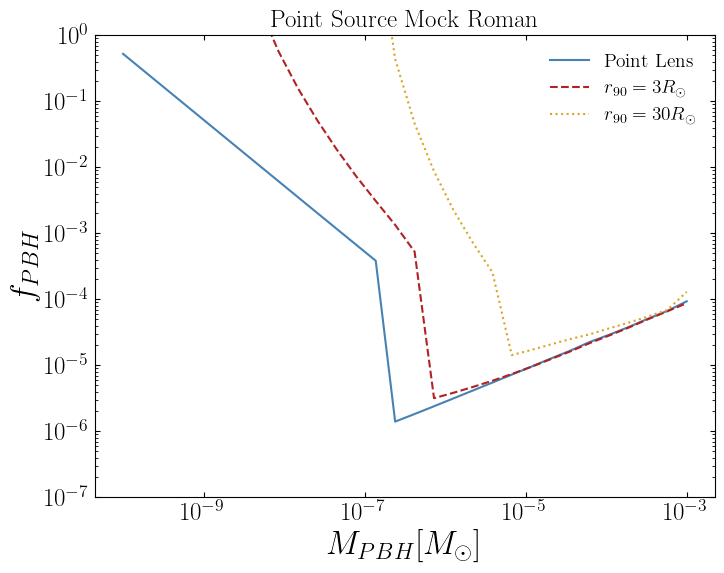

In [145]:
#Efficiency + Real time parameters
plt.loglog(m_arr, fdm_0, label='Point Lens')
plt.loglog(m_arr, fdm_3, label='$r_{90} = 3 R_{\odot}$', ls='--')
plt.loglog(m_arr, fdm_30, label='$r_{90} = 30 R_{\odot}$', ls=':')
plt.ylim(1e-7, 1)
plt.legend()
plt.xlabel('$M_{PBH} [M_{\odot}]$')
plt.ylabel('$f_{PBH}$')
plt.title('Point Source Mock Roman')
plt.show()

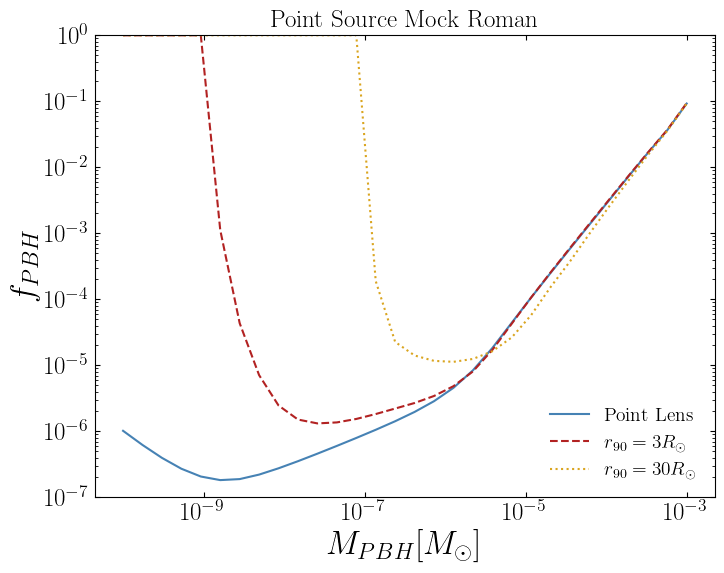

In [137]:
plt.loglog(m_arr, fdm_0, label='Point Lens')
plt.loglog(m_arr, fdm_3, label='$r_{90} = 3 R_{\odot}$', ls='--')
plt.loglog(m_arr, fdm_30, label='$r_{90} = 30 R_{\odot}$', ls=':')
plt.ylim(1e-7, 1)
plt.legend()
plt.xlabel('$M_{PBH} [M_{\odot}]$')
plt.ylabel('$f_{PBH}$')
plt.title('Point Source Mock Roman')
plt.show()

In [85]:
nfw3.rate_mw()

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_53937/2342537050.py:98: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d, t), epsabs=epsabs, epsrel=epsrel)


4.517142147480595e-07

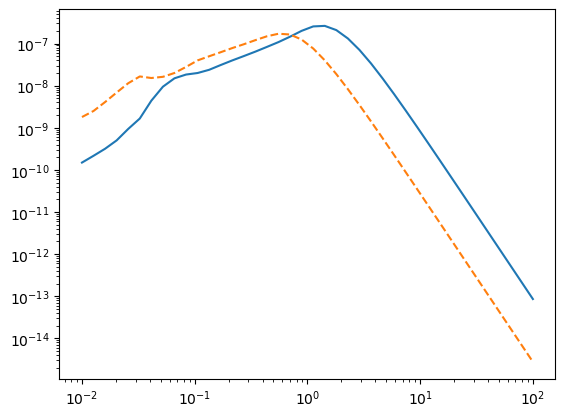

In [84]:
plt.loglog(ts, diff_rate_3)
plt.loglog(ts, diff_rate_30, '--')

### Calculate uT

In [ ]:
def mass_function(t, tm):
    if abs(t) < tm:
        return 1 - (1 - (t/tm)**2)**(1.5)
    else:
        return 1


def general_lensing_equation(t, u, tm):
    m_t = mass_function(t, tm)
    return u - t + m_t/t

def find_image_positions(u, tm):
    
    initial_guesses = [u, tm/2, -tm/2]

    solutions = [fsolve(general_lensing_equation, guess, args=(u, tm))[0] for guess in initial_guesses]

    # unique_solutions = np.unique(np.round(solutions, 8))

    # return unique_solutions
    return solutions


# Example values for u and tm to find the solutions
u_example = 1.1  # Example value for u
tm_example = 0.5  # Example value for tm

# Find the image positions for these example values
image_positions = find_image_positions(u_example, tm_example)
image_positions

[1.6912712210513328, -0.23652745045742374, -0.23652745045741544]

In [ ]:
print(abs(u_example), abs(tm_example - 1/tm_example))

1.1 1.5


In [ ]:
print(1/2 * (u_example + (4 + u_example**2)**(0.5)))
print(1/2 * (u_example - (4 + u_example**2)**(0.5)))
print(u_example/(1-3/(2* tm_example**2)))

1.6912712210513328
-0.5912712210513327
-0.22000000000000003


### Uniform Sphere

In [ ]:
def m_of_t(t, t_m):
    if abs(t)< t_m:
        return 1 - (1-t**2/t_m**2)**(3/2)
    else:
        return 1

def ubar(u, rs, phi):
    return (u**2 + rs**2 + 2*u*rs*np.cos(phi))**0.5

def t_func(u, rs, phi):
    u = ubar(u, rs, phi)
    sol = fsolve(lambda t: u - (t - m_of_t(u_val, t)/t), 0.5)
    if sol.size == 0:
        return np.NaN
    else: 
        return sol[0]

def extended_mag(u, rs):
    return 1/(np.pi * rs**2) * 0.5 * quad(lambda phi: t_func(u, rs, phi)**2, 0, 2*np.pi)[0]

def u_T_func(rs, A_T=1.34):
    return fsolve(lambda u: extended_mag(u, rs) - A_T, 0.5)[0]

In [ ]:
t_func(1, 0.5, 0)

1.687946523434382

In [ ]:
extended_mag(10, 10)

2.000782436807818

In [ ]:
u_T_func(1.7)

In [ ]:
rs_arr = np.logspace(-1, 5, 100)
u_T_arr = np.array([u_T_func(rs) for rs in rs_arr])

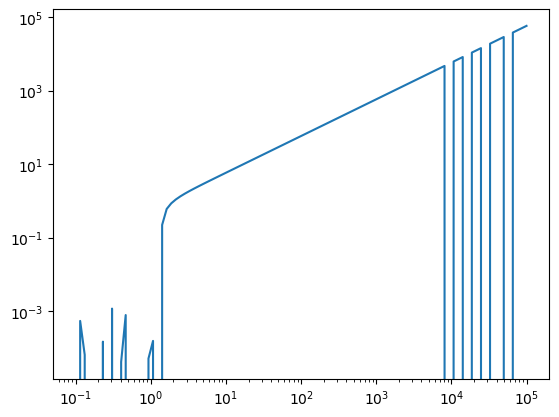

In [ ]:
plt.loglog(rs_arr, u_T_arr)